# Lista 6 - MS211 turma L

para uma descricao detalhada da teoria empregada nesse trabalho, utilize os documentos relatorio.md e lista06.pdf. As contas utilizadas e desenvolvidas nesse trabalho consistem no modelo compartimental SEIR:

$$\begin{cases}
\frac{d\bold{S}}{dt} = -\frac{r_0}{T_{inf}} \bold{S}\bold{I}\\
\frac{d\bold{E}}{dt} = \frac{r_0}{T_{inf}} \bold{S}\bold{I} - \frac{1}{T_{inc}} \bold{E}\\
\frac{d\bold{I}}{dt} = \frac{r_0}{T_{inc}} \bold{E} - \frac{1}{T_{inf}} \bold{I}\\
\frac{d\bold{R}}{dt} = \frac{1}{T_{inf}} \bold{I}
\end{cases}$$

Onde:

- $r_0$ eh o numero de reprodução basal e representa onúmero de pessoas que um doente iria infectar em média durante o curso de sua doença
- $T_{inc}$ eh o tempo de incubacao do virus em uma pessoa exposta
- $T_{inf}$ eh o tempo médio que a pessoa fica infecciosa



Como condicoes de contorno para o problema, teremos dados conhecidos da pandemia de Covid-19, adotando:

- Número de reprodução basal ($r_0$): 2.5, sendo otimista (adimensional)

- Tempos médio de incubação e infecção:$T_{inc}= 5.2$ dias,$T_{inf}= 2.9$ dias

- Demanda de leitos de UTI: estimava-se que 3% dos doentes precisariamde leito de UTI

- Mediana dos tempos de UTI: 7 dias

- Disponibilidade de leitos de UTI na região Sudeste em 2019 (antes dapandemia): 27 por 100 mil habitantes

- Condição inicial:$S_0 = 0.999999$,$E_0 = 10−6$,$I_0= 0$,$R_0= 0$. Ou seja, há uma pessoa por milhão na população que está exposta e ainda não começou a transmitir a doença. Todo o restante da população é suscetível.

Para a resolucao do problema utilizaremos o algoritmo do método do ponto médio para EDO vetoriais.

O horizonte de simulação sera de 498 dias com um passo de um dia.

In [14]:
using LinearAlgebra, Statistics, Random, SparseArrays
using Plots
using LaTeXStrings
using Printf
#using OrdinaryDiffEq
#using Parameters, Plots

In [15]:
porcentagem_taxa_inicial = 1 # mude esse valor entre 0 e 1 para diferentes r0
r0 = porcentagem_taxa_inicial*2.5 # numero de reproducao basal
Tinc = 5.2 # incubacao de 5.2 dias
Tinf = 2.9 # infeccaopor 2.9 dias
prob_UTI = 3/100 # probabilidade de um doente precisar de leito de UTI
t_UTI = 7 # tempo que o doente passa na UTI
S = 0.999999 # sucetiveis iniciais
E = 10^(-6) # expostos iniciais
I = 0 # infectados iniciais
R = 0 # recuperados iniciais
leitos_por_100k = 27 # 27 leitos para cada 100 mil habitantes * total da populacao
days = 498.0 # range of days from simulation
pop = 44.04 * 10^6 # numero de pessoas no modelo
steps = 1 # tamanho do passo dado a cada interacao em dias

1

In [16]:
# epsilon da maquina
@show eps(1.0)

eps(1.0) = 2.220446049250313e-16


2.220446049250313e-16

In [17]:
# essas expressoes estao corretas, eu copiei errado ali em cima

# funcao que retorna as variacoes calculadas com os valores atuais dos parametros
# o valor steps pode ser 0.5 ou 1
function SEIR(S, E, I, R, r0, Tinc, Tinf, steps)
	return [
		-(r0/Tinf)*S*I * steps; #dS
		((r0/Tinf)*S*I - (E/Tinc)) * steps; #dE
		((E/Tinc) - (I/Tinf)) * steps; #dI
		(I/Tinf) * steps; #dR
	]
end

SEIR (generic function with 1 method)

In [18]:
function ponto_medio(SEIR, S, E, I, R, r0, Tinc, Tinf, n_pop, n_days, steps)
	
	# inicia uma matriz de 4 linhas e n_dayscolunas
	y = zeros(4,n_days+ 1)
	dy = zeros(4,n_days+ 1)

	# inicia a primeira coluna com seus respactivos valores
	y[1, 1] = S
	y[2, 1] = E
	y[3, 1] = I
	y[4, 1] = R

	# para cada uma das colunas subsequentes aplique o algoritmo
	for i = 2:n_days + 1

		# calcule a proxima derivada com meio passo dos valores atuais
		result = SEIR(y[1,i - 1], y[2,i - 1],y[3,i - 1], y[4,i - 1], r0, Tinc, Tinf, steps/2)

		# some esse resultado com o valor atual
		y1 = y[1,i - 1] + (steps/2)*result[1]
		y2 = y[2,i - 1] + (steps/2)*result[2]
		y3 = y[3,i - 1] + (steps/2)*result[3]
		y4 = y[4,i - 1] + (steps/2)*result[4]

		# recalcule a derivada com o valor atualizado
		result2 = SEIR(y1, y2, y3, y4, r0, Tinc, Tinf, steps)
		y[1,i] = y[1,i - 1] + steps*result2[1]
		y[2,i] = y[2,i - 1] + steps*result2[2]
		y[3,i] = y[3,i - 1] + steps*result2[3]
		y[4,i] = y[4,i - 1] + steps*result2[4]

		dy[1,i] = result2[1]
		dy[2,i] = result2[2]
		dy[3,i] = result2[3]
		dy[4,i] = result2[4]

	end
	return y, dy
end

ponto_medio (generic function with 1 method)

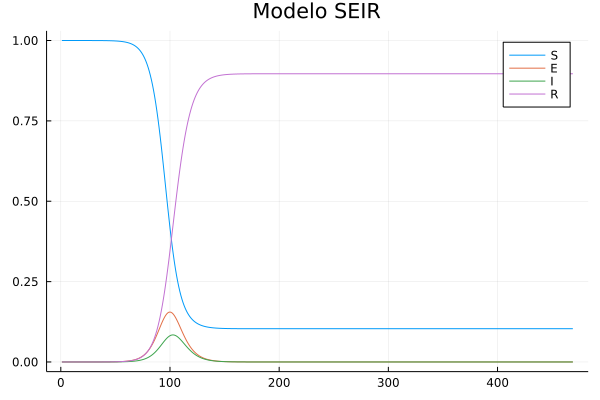

In [19]:
y, dy = ponto_medio(SEIR, S, E, I, R, r0, Tinc, Tinf, pop, 468, 1)
plot([y[1,:],y[2,:],y[3,:],y[4,:]],label=["S" "E" "I" "R"], title = "Modelo SEIR")


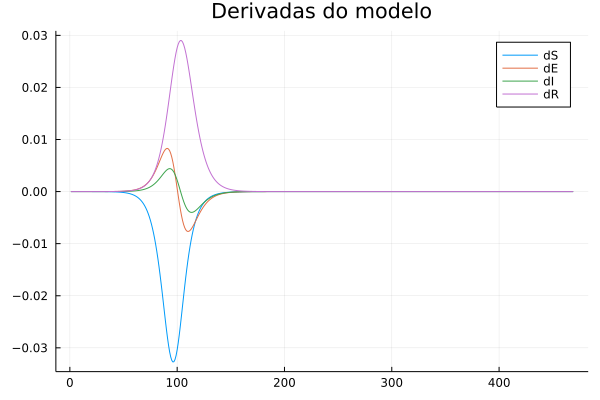

In [20]:
plot([dy[1,:],dy[2,:],dy[3,:],dy[4,:]],label=["dS" "dE" "dI" "dR"], title = "Derivadas do modelo")

### 1. Qual a maior proporção de pessoas doentes observadas em um único dia? Considerando que o estado de São Paulo possui 44,04 milhões de habitantes, essa proporção representa quantas pessoas doentes ao mesmo em um estado como o nosso?

In [21]:
function find_max_I_pop(I, pop)
	result = findmax(I)
	return result[1] * pop, result[2]
end

find_max_I_pop (generic function with 1 method)

In [22]:
max_I, dia_pico = find_max_I_pop(y[3,:],pop)
print("Maior numero de pessoas doentes observadas em um unico dia: ", ceil(Int, max_I),"\n")
print("Maior proporcao de pessoas doentes observadas em um unico dia: ", ceil(Int, (max_I/pop) * 100), '%')

Maior numero de pessoas doentes observadas em um unico dia: 3707403
Maior proporcao de pessoas doentes observadas em um unico dia: 9%

### 2. Quantos dias são necessários para chegar no pico de doentes?

In [23]:
print("Dias para chegar no pico: ", dia_pico)

Dias para chegar no pico: 103

### 3. Estime o número de leitos de UTI para lidar com o pico.

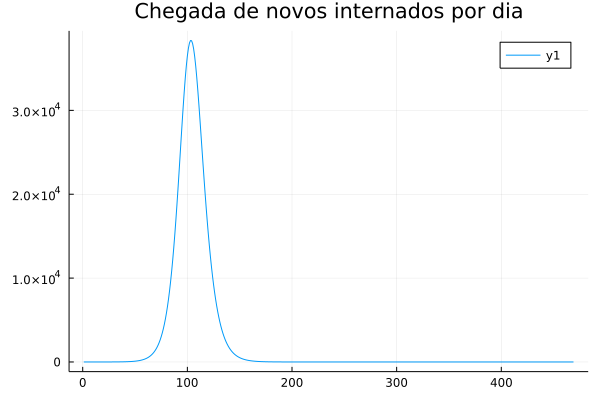

In [24]:
# consideramos o fluxo de doentes para curados por dia e aplicamos a probabilidade
# destes terem ido para a UTI, assim sabemos quantos novos internados temos por dia
function recovered_per_day(dR, pop, prob_UTI)
	result = abs.(dR * pop * prob_UTI)
	return result
end

recovered = recovered_per_day(dy[4,:], pop, prob_UTI)
plot(recovered, title = "Chegada de novos internados por dia")

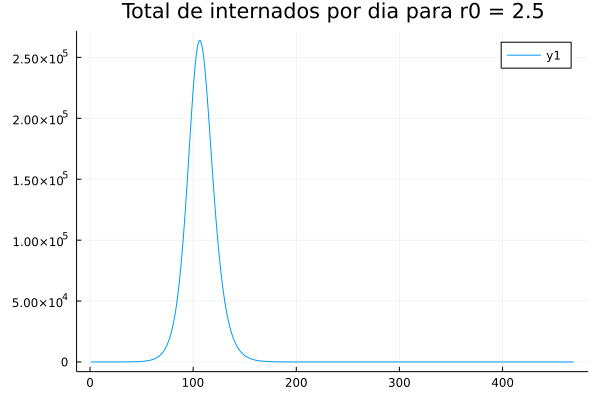

In [25]:
# agora considerando que cada internado leva em media 7 dias para sair da UTI
# podemos calcular o total de internados ao longo dos dias
function leitos_per_day(recovered)
	n = length(recovered)
	leitos = zeros(n)
	for i = 2:n
		leitos[i] = leitos[i - 1] + recovered[i]
		if (i > 8)
			leitos[i] -= recovered[i - 7]
		end
	end
	return leitos
end

internados = leitos_per_day(recovered)
title = join(["Total de internados por dia para r0 = ",string(r0)])
plot(internados, title = title)

In [26]:
# leitos necessarios no pico
print("Leitos necessarios para o pico da pandemia: ", Int(ceil(maximum(internados))))

Leitos necessarios para o pico da pandemia: 263858

### 4. O número de leitos disponíveis é suficiente para lidar com o pico de demanda? Qual o excesso de demanda máximo, se houver?

In [27]:
# calculo do total de leitos disponiveis no estado de SP
function leitos_disp(pop)
	return pop * 27/10^5
end

print("Leitos disponiveis em SP: ", Int(ceil(leitos_disp(pop))))

Leitos disponiveis em SP: 11891

In [28]:
print("Excesso de demanda maximo em SP: ", Int(ceil(maximum(internados)) - ceil(leitos_disp(pop))), " leitos")

Excesso de demanda maximo em SP: 251967 leitos

### 5. Você consegue estimar quantas pessoas ao todo iriam ficar sem acesso a UTIs? Justifique a forma que você fez essa estimativa.

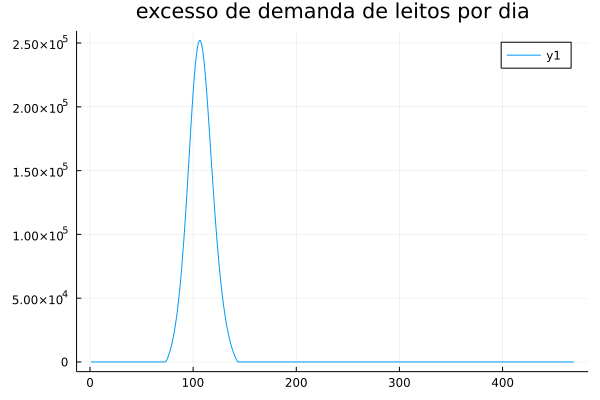

In [29]:
# calculo da populacao total que ficara sem leito
# o calculo foi feito levando em consideracao o total de leitos necessarios por dia
# menos o total de leitos disponiveis
function pop_sem_leito(recovered, pop)
	nescessario = leitos_per_day(recovered)
	falta = zeros(length(nescessario))
	disponivel = leitos_disp(pop)
	for i = 1:length(nescessario)
		if (nescessario[i] - disponivel >= 0)
			falta[i] = nescessario[i] - disponivel
		end
	end

	return falta, sum(falta)
end

result, sums = pop_sem_leito(recovered, pop)
plot(result, title="excesso de demanda de leitos por dia")

In [31]:
print("total de falta de leitos por dia: ", Int(ceil(sums)))
print("total de pessoas sem leito: ", Int(ceil(sums/7)))

total de falta de leitos por dia: 7278377total de pessoas sem leito: 1039769